# Introduction
Imagine that you created a solution, and that you decided to develop a new version of that solution. The solution could be anything, such as new treatment to fight cancer, or a new webpage for an ecommerce website. 

In this notebook, we would like to test the effect of the new solution on a given metric to decide whether we should launch the new version of the solution or not. To do this, this notebook is divided into 4 parts:
- Prerequisites
- Experiment Design
- Running Experiment
- Result to Decision

In this notebook, we assume that we want to know whether the new version of a webpage will improve a given metric, defined later in this experiment.

# Experiment Prerequisites
Before running the experiment, we need to clarify: the experiment's objective(s) and key metric(s), the product variants, and the randomization units.

## Objective & Key Metrics:
For this experiment, we assume that we want to test the consequence on the " purchase conversion" also called "conversion rate" using the following equation:
- Purchase Conversion = Nb. Converted Users / Nb. Exposed Users

To do this, we need to define the terms "exposure" and "conversion":
- Exposure: A user is exposed to its respective variant(here, the webpage version)
- Conversion: A user purchases a product within 7 days after being exposed to the variant(here, the webpage version).

## Randomization unit: 
Assumption: In this experiment, we assume that there are enough users (or total number of observations) in our experiment.

## Product Variants:
Assumption: In this experiment, we assume that the number of users in control group and treatment group are similar.

# Experiment Design
In order to design an experiment properly, we need to answer a few questions:
- Do we want to target all the users or a specific segment of users? 
- When does the effect is practically significant?
- When do we conclude that the probability of detecting an effect is real?
- When do we conclude that an effect is real when it's actually due to chance?
- What is the size of the experiment?
- How long should we run the experiment to get enough data?
- What is the plan to collect the data of the experiment?

## Target population:
In the case study presented in this notebook, it could be possible to analyze the user's journey (funnel). For example, we could select only the users who have the intention to buy products and who started checking out.

## Practical significance boundary:
Practical significance boundary, also known as "effect size" must be defined. In the use case presented in this notebook, we could say that an increase of 2% in average conversion rate (the metric chosen) is practically significant. As a result, if there is a 2% in average conversion rate, we could launch the change to production.

In [1]:
significant_lift = 2

## Power of the test:
The "power of the test", is the probability of True Positive, which is when we detect a given "effect size" (or practical significance) when the effect is real. 
- Probability = 1 - Beta. 

The industry standard in our case is: 
- Power = 80%

In [2]:
power = 0.8

## Significance Level (alpha):
The significance level (alpha) represents the probability of obtaining a False Positive (Type II error): when we mistakenly conclude that an effect is real when it's actually due to chance. 
- Probability = alpha

The industry standard in our case is: 
- Significance level = 5%

In [3]:
alpha = 0.05

## Sample size:
Now, we want to know the sample size of the experiment, or in other words, the number of users allocated randomly in each group. To do this, the following equation can be used:

- Sample size = (16*sigma^2) / delta^2
with sigma the standard deviation of the population, and delta the difference between treatment and control.

To help with calculations, let's assume sigma is equal to 20. Then, the sample size is 16*20^2 / 2^2 = 1600 unique users in each variant. If there are 2 variants, we need at least a total population of 3200 unique users for 2 variants.

If a smaller "effect size" (practical significance boundary, e.i.: USD 1/user) or a smaller significance level (alpha=2.5%) has to be detected, then the sample size has to be increased.

## Duration: 
When planning the duration of the experiment, number of elements can affect the duration of an experiment and need to be considered:
- Latency
- Time required to get the data
- Day of week effect: People behave differently during an entire week. As a result, the experiment should run for at least an entire week to capture this effect. 
- Seasonality: It is possible that data collected during holidays cannot be used for analysis. Therefore, the experiment must run longer.
- Primacy or novelty effects: Users respond to changes differently, and the duration of the experiment must be chosen carefully to avoid a response due to the fact that the solution is a novelty.

Defining a ramp-up plan allows to have no bugs and handle traffic without latency by exposing the new version to a small population and gradually increase the percentage.

Example: 
- day 1: 5% of the treatment group
- day 2: increase to 10% of the treatment group
- etc. 

In our case, the data collected represents 3 weeks of exposure / conversion data.

# Running Experiment

## Import
First, Let's import useful Python libraries:

In [4]:
import pandas as pd
import datetime
from random import sample
from random import seed
from scipy.stats import beta
import numpy as np

import warnings
warnings.filterwarnings("ignore")

## Data collection & Sanity check
The data was collected and added to a CSV file. Each row is logged when a user is exposed to a variant. A first analysis must be performed to make sure that the data was collected properly based on a few assumptions:
- No interaction effects between units in control / treatment groups.
- Number of users assigned to groups is respected and random.
- Consistency for each variant: Latency when using the product is similar, as it could affect the results.

If the sanity check passes, we can continue with analysis. If it fails, we need to look into root cause, discard the results, or correct the data collected (if possible). To do this, let's import and visualize the data collected in this notebook using Pandas library, print the number of data collected

In [5]:
df = pd.read_csv('data_modified.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


The columns are defined below:
- "timestamp": time of exposure
- "group":
    - "control" group
    - "treatment" group
- "landing_page":
    - variant "new_page"
    - variant "old_page"
- "converted": 
   - "1": converted (purchase within 7 days after exposure)
   - "0": not converted (not purchase within 7 days after exposure)

In [6]:
print(f'The lenght of the dataset is: {len(df)}')

The lenght of the dataset is: 294478


In [7]:
print(f"Statistics about the data collected: \n{df.describe()}")

Statistics about the data collected: 
             user_id      converted
count  294478.000000  294478.000000
mean   787974.124733       0.122485
std     91210.823776       0.327845
min    630000.000000       0.000000
25%    709032.250000       0.000000
50%    787933.500000       0.000000
75%    866911.750000       0.000000
max    945999.000000       1.000000


In [8]:
start_time = datetime.datetime.strptime(df['timestamp'].min(), '%Y-%m-%d %H:%M:%S.%f') # start of the data collection
end_time = datetime.datetime.strptime(df['timestamp'].max(), '%Y-%m-%d %H:%M:%S.%f') #end of the data collection
data_duration = (end_time - start_time).days #number of days of the experiment

t = df['user_id'].nunique()
a = int(df[df['group'] == 'treatment'].shape[0]) # Number of subjects in treatment group
b = int(df[df['group'] == 'control'].shape[0]) # Number of subjects in control group A

print(f"Nb. of unique user_id in experiment: {t}")
print(f"Nb. of total entries in experiment: {df.shape[0]}")
print(f"Nb. of users in treatment group: {a}")
print(f"Nb. users in control group: {b}")
print(f"Duration: {data_duration} days.")

Nb. of unique user_id in experiment: 290584
Nb. of total entries in experiment: 294478
Nb. of users in treatment group: 147276
Nb. users in control group: 147202
Duration: 21 days.


### Data cleaning

In [9]:
counter = df['user_id'].value_counts()
mistake = (counter > 1).value_counts()
print(mistake)
print(f"{mistake[1]} user_ids have been exposed to an old and new page. Those data should be removed as they do not represent a big part of the data collected")

False    286690
True       3894
Name: user_id, dtype: int64
3894 user_ids have been exposed to an old and new page. Those data should be removed as they do not represent a big part of the data collected


In [10]:
valid_users = pd.DataFrame(counter[counter == 1].index, columns=['user_id'])
df = df.merge(valid_users, on=['user_id'])

### Data engineering

In [11]:
#Add week column:
df['week'] = df['timestamp'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').isocalendar()[1])
number_of_week = df['week'].value_counts()
df.head()

,user_id,timestamp,group,landing_page,converted,week
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,3
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,2
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,3


In [12]:
print(number_of_week)

2    91380
3    91056
1    83745
4    20509
Name: week, dtype: int64


## Hypothesis tests

### Defining Variables

In [13]:
# Variables that fully define the A/B test results
NUM_WEEKS = number_of_week.shape[0]
experiment_data = df[df['week'] <= NUM_WEEKS]
control = experiment_data[experiment_data['group'] == 'control']
treatment = experiment_data[experiment_data['group'] == 'treatment']

a = treatment['converted'].count() # Number of subjects in treatment group
b = control['converted'].count() # Number of subjects in control group
t = a+b #total nummber of subjects in the experiment

a_yes = treatment['converted'].sum() # Yes count in treatment group
b_yes = control['converted'].sum() # Yes count in control group

#Compute remaining A/B test results
t_yes = a_yes + b_yes # Total yes count
t_no = t - t_yes # Total no count
a_yes_pc = 100* a_yes / a # Yes percentage in treatment group
b_yes_pc = 100* b_yes / b # Yes percentage in control group

# A/B testing Statistic: Yes percentage change difference (A-B)
ab_yes_pc = ((b_yes_pc - a_yes_pc) / abs(b_yes_pc))*100

print(f"- Nb. of unique user_id in experiment: {t}")
print(f"- Nb. of total entries in experiment: {df.shape[0]}")
if t != df.shape[0]:
    print("WARNING!: The number of unique user_id and total entries in the experiment is different!")

print(f"- Nb. of users in treatment group: {a}")
print(f"- Nb. users in control group: {b}")
print(f"- Duration of the Experiment: {data_duration} days.")

print(f'- Observed Yes rate for A (treatment conversion rate): {round(a_yes_pc,3)}% \n- Observed Yes rate for B (control conversion rate): {round(b_yes_pc,3)}%, \n- A-B (Lift): {round(ab_yes_pc, 3)}%, \n- Total counts: Yes: {t_yes}, No: {t_no}')

- Nb. of unique user_id in experiment: 286690
- Nb. of total entries in experiment: 286690
- Nb. of users in treatment group: 143397
- Nb. users in control group: 143293
- Duration of the Experiment: 21 days.
- Observed Yes rate for A (treatment conversion rate): 12.44% 
- Observed Yes rate for B (control conversion rate): 12.017%, 
- A-B (Lift): -3.514%, 
- Total counts: Yes: 35058, No: 251632


### Doing p Permutations

In [14]:
seed(2) # For reproducible results

bag = [1]*t_yes + [0]*t_no #S1 : create a bag with all the data

p = 1000 # number of permutations
perm_res = [0]*p # list for permutation results

for i in range (p):
    bag = sample(bag, k=len(bag)) # S2: Shuffle the bag
    a_rs = bag[:a]                # S3: Random sample A
    b_rs = bag[a:]                # S4: Random sample B
    # Step 5: Compute the test statistic
    perm_res[i] = 100*sum(a_rs)/a - 100*sum(b_rs)/b

# Print representation of the Null hypothesis and can be used to compute the p-value
# n = 5
# for i in range(0, len(perm_res), n):
#     print(str(perm_res[i:i+n]).replace(",", "").replace(".0", ""))

Reminder about Powers and Errors:
- Power: Probability of detecting a give effect size when the effect is real (True Positive). 
- Type I error (False Negative): Mistakenly concluding that an effect is due to chance(when it's actually real). Probability = Beta
- Type II error (False Positive): Mistakenly concluding that an effect is real (when it's actually due to chance). Probability = Alpha

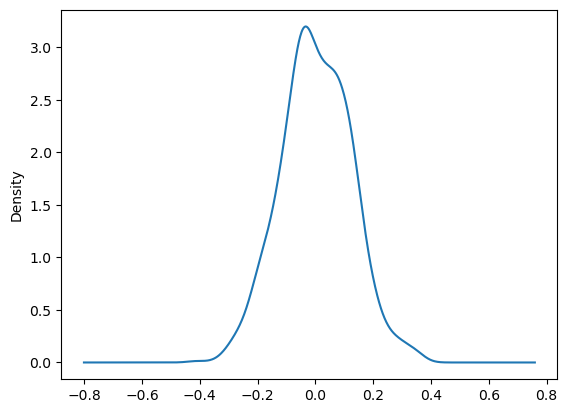

In [15]:
# Transform list to pandas series:
perm_res_s = pd.Series(perm_res)
#print(pd.pivot_table(perm_res_s.value_counts().reset_index(), values = 0, columns = "index").to_string(index=False))
#ax = perm_res_s.plot.hist(bins=100, alpha=1)
ax1= perm_res_s.plot.kde()

### Frequentist approach

In [16]:
# Two-way hypothesis test (Null: A = B, Alternative: A != B)
extreme_count = sum(perm_res_s.abs() >= abs(ab_yes_pc))
p_value = extreme_count / p

# One-way hypothesis test (Null: A <= B, Alternative: A > B)
pos_extreme_count = sum(perm_res_s >= ab_yes_pc)

print("Number of permutations:", p, 
    "\nTwo-way Hypothesis Test: (Null: A = B, Alternative: A != B)"
    "\nExtreme count          :", extreme_count,
    "\nExtreme ratio (p-value):", p_value,)
   #  "\nOne-way: Extreme count          :", pos_extreme_count,
   #  "\nOne-way: Extreme ratio (p-value):", pos_extreme_count / p)

Number of permutations: 1000 
Two-way Hypothesis Test: (Null: A = B, Alternative: A != B)
Extreme count          : 0 
Extreme ratio (p-value): 0.0


In [17]:
if p_value > alpha:
    print(f"The null hypothesis CANNOT be rejected! \nThe p-value is bigger than the significance level (0.05):\n ({p_value} > {alpha})")
else:
    print(f"The null hypothesis CAN be rejected! \nThe p-value = {round(p_value,10)} is smaller than the significance level (0.05):\n ({p_value} < {alpha})")

The null hypothesis CAN be rejected! 
The p-value = 0.0 is smaller than the significance level (0.05):
 (0.0 < 0.05)


### Bayesian approach
The baysian approach can provide a much better grasp of the result by providing a posterior distribution that can be compared with the distribution before the experiment started (prior). 

We can therefore output a result that is an actionable statement such as: "We can be X% confident that the lift is Y%"

The bayes theorem is intended to be used multiple times, each time gaining new evidence and update that an hypothesis is true. When Richard price introduced Bayes' Theorem, he made an analogy to a man coming out of a cave, who never seen the outside world before. He saw the Sun rise for the first time, and thought to himself: Is the sun rising a one-off event or does the Sun always do this? Every day after that, as the Sun rose again, he could get a little bit more confident about the way the world work.

Assumption:
In this example, we cannot access prior data, as a result the data of the first week is considered as the prior data, and the rest of the data as the posterior data.

Let's create the prior beta distribution from the first weeks of converstion data:

In [18]:
prior = df[(df['week'] == 1) & (df['group'] == 'control')]

Then, we take 10000 samples of purchase conversions rate

In [19]:
prior_means = []
for i in range(10000):
    prior_means.append(prior.sample(1000)['converted'].mean())

Feed the sample to model a Beta Distribution from sample means:

In [20]:
prior_alpha, prior_beta, _, _= beta.fit(prior_means, floc=0, fscale=1)

In [21]:
# Variables that fully define the A/B test results
NUM_WEEKS = number_of_week.shape[0]-1
experiment_data = df[(df['week'] > 1) & (df['week'] <= NUM_WEEKS)]
control = experiment_data[experiment_data['group'] == 'control']
treatment = experiment_data[experiment_data['group'] == 'treatment']

a = treatment['converted'].count() # Number of subjects in treatment group
b = control['converted'].count() # Number of subjects in control group
t = a+b #total nummber of subjects in the experiment

a_yes = treatment['converted'].sum() # Yes count in treatment group
a_no = treatment['converted'].count() - a_yes #No count in treatment group

b_yes = control['converted'].sum() # Yes count in control group
b_no = control['converted'].count() - b_yes # No count in control group

posterior_treatment = beta(prior_alpha + a_yes, prior_beta + a_no)
posterior_control = beta(prior_alpha + b_yes, prior_beta + b_no)

# Sample from Posteriors
control_samples = posterior_control.rvs(1000)
treatment_samples = posterior_treatment.rvs(1000)
# probability = np.mean(treatment_samples > control_samples)

#Compute remaining A/B test results
t_yes = a_yes + b_yes # Total yes count
t_no = t - t_yes # Total no count
a_yes_pc = 100* a_yes / a # Yes percentage in treatment group
b_yes_pc = 100* b_yes / b # Yes percentage in control group

# A/B testing Statistic: Yes percentage difference (A-B)
ab_yes_pc = ((b_yes_pc - a_yes_pc) / abs(b_yes_pc))*100

print(f"- Nb. of unique user_id in experiment: {t}")
print(f"- Nb. of total entries in experiment: {df.shape[0]}")
if t != df.shape[0]:
    print("WARNING!: The number of unique user_id and total entries in the experiment is different!")

print(f"- Nb. of users in treatment group: {a}")
print(f"- Nb. users in control group: {b}")
print(f"- Duration of the Experiment: {data_duration} days.")

print(f'- Observed Yes rate for A (conversion rate of treatment group): {round(a_yes_pc,2)}% \n- Observed Yes rate for B (conversion rate of control group): {round(b_yes_pc,2)}%, \n- A-B (Lift): {round(ab_yes_pc, 2)}%, \n- Total counts: Yes: {t_yes}, No: {t_no}')
# print(f"Probability that treatment > control: {probability * 100}%")

- Nb. of unique user_id in experiment: 182436
- Nb. of total entries in experiment: 286690
WARNING!: The number of unique user_id and total entries in the experiment is different!
- Nb. of users in treatment group: 91213
- Nb. users in control group: 91223
- Duration of the Experiment: 21 days.
- Observed Yes rate for A (conversion rate of treatment group): 12.48% 
- Observed Yes rate for B (conversion rate of control group): 12.03%, 
- A-B (Lift): -3.79%, 
- Total counts: Yes: 22355, No: 160081


In [22]:
(control_mu), (control_var) = posterior_control.stats()
(treatment_mu), (treatment_var) = posterior_treatment.stats()
print(f"Control Posterior: Mean: {control_mu}, Variance: {control_var}") 
print(f"Treatment Posterior: Mean: {treatment_mu}, Variance: {treatment_var}") 

Control Posterior: Mean: 0.1202423011848952, Variance: 1.1467379699393633e-06
Treatment Posterior: Mean: 0.12475462472776712, Variance: 1.1837974443138027e-06


# Result to Decision
The results are checked and interpreted to make decisions.

In [23]:
lift_percentage = (treatment_samples - control_samples) / control_samples
proba = round(np.mean((100 * lift_percentage) > significant_lift) * 100,3)
print(f"Probability that we are seeing a {significant_lift}% lift is {proba}%")

Probability that we are seeing a 2% lift is 92.4%


In [24]:
desired_lift_max = 100
desired_lift_in_percent = 0
result = pd.DataFrame(columns=['desired_lift', 'probability'])

for x in range(desired_lift_max):
    lift_percentage = (treatment_samples - control_samples) / control_samples
    desired_lift_in_percent = int(desired_lift_in_percent + 1)
    probability = round(np.mean((100 * lift_percentage) > desired_lift_in_percent) * 100,3)
    result = result.append({'desired_lift': desired_lift_in_percent, 'probability': probability/100}, ignore_index=True)

result.head(10)

,desired_lift,probability
0,1.0,0.982
1,2.0,0.924
2,3.0,0.707
3,4.0,0.414
4,5.0,0.166
5,6.0,0.048
6,7.0,0.008
7,8.0,0.001
8,9.0,0.000
9,10.0,0.000


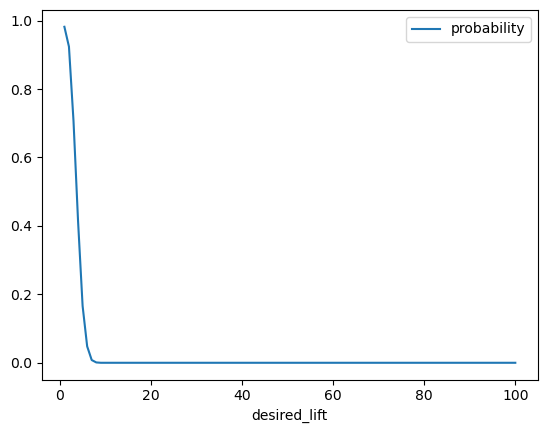

In [25]:
lines = result.plot.line(x='desired_lift', y='probability')

Advantages of Bayesian over Frequentist:
- Results are more interpretable than the ones we got from the frequentist approach
- We can interpret results at any point during the experiment.

## Decision
It is recommended to launch a change when the result is:
- Statistically significant (based on p-value, if Confidence interval overlaps with 0: NOT statistically significant)
- Practically significant (based on point estimate > practical significance boundary USD 2 / user)

If it is not the case, it is required to run a follow-up test with more power 
- Tradeoffs between different metrics: If different metrics move in different directions, such as revenue and user engagment.
- Costs of launching: When costs are high, we need to make sure the benefit overwheigh the cost (using a practical significance boundary). When costs are low, any positive changes should be launched.

In [26]:
if proba >= power and p_value < alpha:
    print("- The test is statistically significant AND practically significant")
    print(f"- Probability that we are seeing a {significant_lift}% lift is {proba}%")
    print("- Based on the results, the version should be launched")
elif proba < power and p_value < alpha:
    print("The test is statistically significant, but NOT practically significant")
    print(f"- Probability that we are seeing a {significant_lift}% lift is {proba}%")
    print("- Based on the results, the version should NOT be launched")
elif proba >= power and p_value > alpha:
    print("The test is NOT statistically significant, but it is practically significant")
    print("- Based on the results, the version should NOT be launched")
elif proba < power and p_value > alpha:
    print("The test is NOT statistically significant, and NOT practically significant")
    print(f"- Probability that we are seeing a {significant_lift}% lift is {proba}%")
    print("- Based on the results, the version should NOT be launched")

- The test is statistically significant AND practically significant
- Probability that we are seeing a 2% lift is 92.4%
- Based on the results, the version should be launched


# Post-Launch monitoring
Long-term effect may be different from short-term effect. As a result, it is a good idea to monitor the effect after launching the change.

# Note

If you want to randomly modify the nunmber of conversion in the treatment group for experiment, you can use this little piece of code:

In [27]:
# import random
# for row in df.itertuples():
#     r = random.randint(0,150)
#     if r == 1 and df.at[row.Index, "group"] == 'treatment':
#         df.at[row.Index, "converted"] = 1
# df.to_csv('data_modified.csv', index=False)